# 1. Loading Data

In [1]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# # Google Colab trick to extend memory
# a = []
# while(1):
#     a.append('1')


## 1.1 Functions

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    


## 1.2 Loading data grid


In [3]:
# Mount google drive
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
# Setting directories where data is stored and ouptut dir
if IN_COLAB:
    DATA_GRID_INPUT_DIR = './drive/My Drive/Colab Notebooks' 
    DATA_OUTPUT_DIR = './drive/My Drive/Colab Notebooks'
    !ls './drive/My Drive/Colab Notebooks'
else:
    DATA_GRID_INPUT_DIR = '.'
    DATA_OUTPUT_DIR = '.'

In [5]:
print('Loading the data...')

data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_model2.pkl')

Loading the data...


## 1.3 Init variables

In [6]:
h = 28 # Prediction horizon
max_lags = 120 # Max lags used
TRAINING_LAST_DAY_NUM = 1913 # Last day for training data
FIRST_PRED_DAY = datetime(2016,4, 25) # First prediction day
FIRST_LOADING_DAY = datetime(2013, 4,7) # First day for training
FIRST_LOADING_DAY_NUM = 800
SEED = 7


# 2. Feature Engineering

## Creating features


In [7]:
def create_features(df):


    lags = [1, 7, 14, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]
  
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)
        
    wins = [7, 14, 28, 60]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)

    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)        
    
    
    date_features = {
        
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     df.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
            
    
    return df
    

In [8]:
%%time

data = create_features(data)

CPU times: user 8min 23s, sys: 24.2 s, total: 8min 47s
Wall time: 10h 20min 1s


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 47 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  object        
 1   item_id             int16         
 2   dept_id             int8          
 3   store_id            int8          
 4   cat_id              int8          
 5   state_id            int8          
 6   d                   object        
 7   sales               float16       
 8   date                datetime64[ns]
 9   wm_yr_wk            int16         
 10  weekday             int8          
 11  wday                int16         
 12  month               int16         
 13  year                int16         
 14  event_name_1        int8          
 15  event_type_1        int8          
 16  event_name_2        int8          
 17  event_type_2        int8          
 18  snap_CA             float16       
 19  snap_TX             float16       
 20  

In [10]:
data.dropna(inplace = True)
data.shape

(43375450, 47)

In [11]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t1,lag_t7,lag_t14,lag_t28,rmean_1_7,rmean_7_7,rmean_14_7,rmean_28_7,rmean_1_14,rmean_7_14,rmean_14_14,rmean_28_14,rmean_1_28,rmean_7_28,rmean_14_28,rmean_28_28,rmean_1_60,rmean_7_60,rmean_14_60,rmean_28_60,price_mean_t60,price_momentum_t60,woy,quarter,mday
1112583,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_88,8.0,2011-04-26,11113,5,4,4,2011,22,3,0,0,0.0,0.0,0.0,0.500000,10.0,5.0,6.0,0.0,9.000000,1.571289,5.714844,0.000000,5.355469,3.642578,4.429688,0.000000,4.679688,2.607422,2.214844,0.643066,2.482422,1.983398,2.017578,2.416016,0.434570,1.150391,17,2,26
1112584,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_89,1.0,2011-04-27,11113,6,5,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,8.0,23.0,6.0,0.0,9.429688,4.000000,4.714844,0.000000,5.500000,4.355469,4.855469,0.000000,4.964844,3.427734,2.427734,0.643066,2.617188,2.199219,1.966797,2.216797,0.436035,1.146484,17,2,27
1112585,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_90,0.0,2011-04-28,11113,4,6,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,1.0,0.0,0.0,0.0,6.285156,4.000000,2.857422,0.000000,5.144531,3.427734,4.855469,0.000000,5.000000,3.427734,2.427734,0.643066,2.632812,2.132812,1.916992,1.966797,0.437256,1.143555,17,2,28
1112586,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_91,0.0,2011-04-29,11113,0,7,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,6.285156,4.000000,2.857422,0.000000,5.144531,3.427734,4.855469,0.000000,5.000000,3.427734,2.427734,0.643066,2.632812,2.066406,1.916992,1.966797,0.438721,1.139648,17,2,29
1112590,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_88,0.0,2011-04-26,11113,5,4,4,2011,22,3,0,0,0.0,0.0,0.0,1.769531,0.0,8.0,0.0,2.0,3.000000,3.142578,1.286133,0.714355,2.500000,2.214844,1.357422,1.357422,2.000000,1.642578,1.357422,2.035156,1.983398,2.000000,1.849609,2.099609,1.696289,1.042969,17,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469,1.0,0.0,2.0,1.0,0.571289,1.000000,1.571289,0.714355,0.928711,1.286133,1.000000,0.856934,0.928711,0.928711,0.928711,1.250000,1.033203,1.000000,1.000000,0.933105,3.980469,1.000000,16,2,24
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,3.0,0.0,1.0,2.0,0.714355,0.856934,1.142578,1.142578,0.856934,1.000000,1.071289,1.286133,1.000000,1.036133,1.178711,1.107422,0.950195,0.916504,1.000000,1.033203,1.280273,1.000000,16,2,23
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,1.0,2.0,4.0,0.856934,0.714355,1.286133,1.571289,0.856934,1.000000,0.928711,1.357422,0.964355,1.036133,1.142578,1.250000,0.966797,0.933105,1.033203,1.099609,1.280273,1.000000,16,2,24
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.0,0.000000,0.000000,1.286133,2.285156,0.071411,0.643066,2.500000,2.214844,1.250000,1.821289,2.357422,1.786133,1.549805,1.666992,1.983398,1.766602,1.000000,1.000000,16,2,23


## Reduce mem usage of created features

In [12]:
data = reduce_mem_usage(data)

Mem. usage decreased to 4384.80 Mb (4.5% reduction)


In [13]:
gc.collect()

40

# 3. Fit & Predict

In [14]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.head()

Data usage: 4.5977977 GB


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t1,lag_t7,lag_t14,lag_t28,rmean_1_7,rmean_7_7,rmean_14_7,rmean_28_7,rmean_1_14,rmean_7_14,rmean_14_14,rmean_28_14,rmean_1_28,rmean_7_28,rmean_14_28,rmean_28_28,rmean_1_60,rmean_7_60,rmean_14_60,rmean_28_60,price_mean_t60,price_momentum_t60,woy,quarter,mday
1112583,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_88,8.0,2011-04-26,11113,5,4,4,2011,22,3,0,0,0.0,0.0,0.0,0.500000,10.0,5.0,6.0,0.0,9.000000,1.571289,5.714844,0.000000,5.355469,3.642578,4.429688,0.000000,4.679688,2.607422,2.214844,0.643066,2.482422,1.983398,2.017578,2.416016,0.434570,1.150391,17,2,26
1112584,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_89,1.0,2011-04-27,11113,6,5,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,8.0,23.0,6.0,0.0,9.429688,4.000000,4.714844,0.000000,5.500000,4.355469,4.855469,0.000000,4.964844,3.427734,2.427734,0.643066,2.617188,2.199219,1.966797,2.216797,0.436035,1.146484,17,2,27
1112585,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_90,0.0,2011-04-28,11113,4,6,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,1.0,0.0,0.0,0.0,6.285156,4.000000,2.857422,0.000000,5.144531,3.427734,4.855469,0.000000,5.000000,3.427734,2.427734,0.643066,2.632812,2.132812,1.916992,1.966797,0.437256,1.143555,17,2,28
1112586,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_91,0.0,2011-04-29,11113,0,7,4,2011,0,0,0,0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,6.285156,4.000000,2.857422,0.000000,5.144531,3.427734,4.855469,0.000000,5.000000,3.427734,2.427734,0.643066,2.632812,2.066406,1.916992,1.966797,0.438721,1.139648,17,2,29
1112590,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_88,0.0,2011-04-26,11113,5,4,4,2011,22,3,0,0,0.0,0.0,0.0,1.769531,0.0,8.0,0.0,2.0,3.000000,3.142578,1.286133,0.714355,2.500000,2.214844,1.357422,1.357422,2.000000,1.642578,1.357422,2.035156,1.983398,2.000000,1.849609,2.099609,1.696289,1.042969,17,2,26


In [15]:
# train_end_dt = datetime(2016, 3, 27)
# valid_end_dt = datetime(2016, 4, 24)

valid_start = datetime(2016, 3, 28)
train_valid_end_dt = datetime(2016, 4, 24)

In [16]:
%%time

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weights"] + \
                ['lag_t1']  # lag_t1 leads to overfitting
train_cols = data.columns[~data.columns.isin(useless_cols)]

X_train = data[train_cols]
y_train = data["sales"]

X_valid= data.loc[(data.date >= valid_start) & (data.date <=train_valid_end_dt), train_cols]
y_valid = data.loc[(data.date >= valid_start) & (data.date <= train_valid_end_dt), "sales"]

del data
gc.collect()

X_train_np = X_train.values.astype(np.float16)
X_valid_np = X_valid.values.astype(np.float16)

del X_train, X_valid
gc.collect()

train_data = lgb.Dataset(X_train_np, label = y_train, feature_name = list(train_cols), categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_valid_np, label = y_valid, feature_name = list(train_cols), categorical_feature=cat_feats, free_raw_data=False)


CPU times: user 15.4 s, sys: 9.09 s, total: 24.5 s
Wall time: 26.8 s


In [17]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'num_leaves': 2**11-1,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 1400,
            'boost_from_average': False,
            'verbose': 1,
            'n_jobs': 4, # For local computation optimization
            'seed': SEED,
} 


In [18]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], 
                  verbose_eval=50)


[50]	training's rmse: 2.61402	valid_1's rmse: 2.10618
[100]	training's rmse: 2.34638	valid_1's rmse: 1.92217
[150]	training's rmse: 2.30119	valid_1's rmse: 1.90548
[200]	training's rmse: 2.27199	valid_1's rmse: 1.89576
[250]	training's rmse: 2.2535	valid_1's rmse: 1.889
[300]	training's rmse: 2.24043	valid_1's rmse: 1.88435
[350]	training's rmse: 2.23011	valid_1's rmse: 1.88022
[400]	training's rmse: 2.22178	valid_1's rmse: 1.87607
[450]	training's rmse: 2.21402	valid_1's rmse: 1.87256
[500]	training's rmse: 2.20679	valid_1's rmse: 1.86938
[550]	training's rmse: 2.19971	valid_1's rmse: 1.86584
[600]	training's rmse: 2.19323	valid_1's rmse: 1.86316
[650]	training's rmse: 2.18727	valid_1's rmse: 1.85998
[700]	training's rmse: 2.18182	valid_1's rmse: 1.85708
[750]	training's rmse: 2.17711	valid_1's rmse: 1.8543
[800]	training's rmse: 2.17197	valid_1's rmse: 1.85174
[850]	training's rmse: 2.16659	valid_1's rmse: 1.84913
[900]	training's rmse: 2.16145	valid_1's rmse: 1.8466
[950]	training's

In [19]:
os.system('say "Training complete"')

0

In [20]:
m_lgb.save_model(f'{DATA_OUTPUT_DIR}/model.lgb')
m_lgb = lgb.Booster(model_file=f'{DATA_OUTPUT_DIR}/model.lgb')

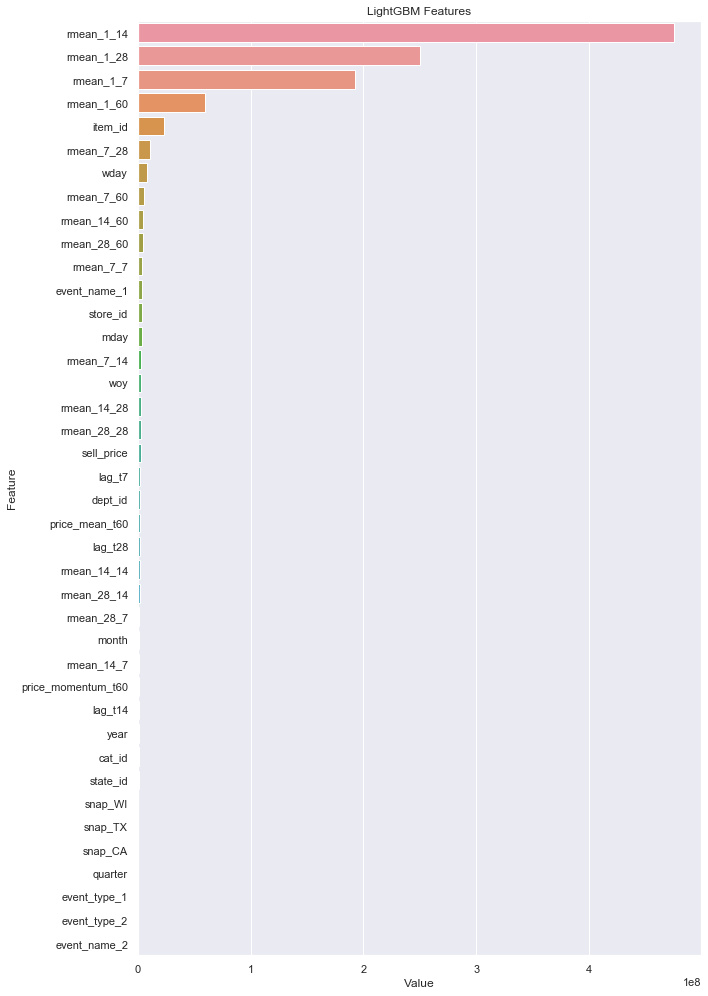

In [21]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance("gain"), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

# Change size of the plot, so we can see all features
fig_dims = (10, 14)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x="Value", y="Feature", ax=ax, data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [22]:
# Detection of features with zero-importance
zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
print(zero_features)
feature_importance


There are 0 features with 0.0 importance
[]


,Value,Feature
23,4.755719e+08,rmean_1_14
27,2.502586e+08,rmean_1_28
19,1.921699e+08,rmean_1_7
31,5.940250e+07,rmean_1_60
0,2.323846e+07,item_id
28,1.054241e+07,rmean_7_28
5,8.639594e+06,wday
32,5.653052e+06,rmean_7_60
33,5.091681e+06,rmean_14_60
34,5.062866e+06,rmean_28_60


In [23]:
%%time 

tdata = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_test_model2.pkl')

CPU times: user 311 ms, sys: 240 ms, total: 551 ms
Wall time: 672 ms


In [24]:
def create_lag_features_for_test(df, day):
          
    # create lag feaures just for single day (faster)
    lags = [1, 7, 14, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df.loc[df.date == day, lag_col] = df.loc[df.date ==day-timedelta(days=lag), 'sales'].values  # !!! main
        
    wins = [7, 14, 28, 60]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            df_win = df[(df.date <= day-timedelta(days=lag)) & (df.date > day-timedelta(days=lag+win))]
            df_win_grouped_mean = df_win.groupby("id").agg({'sales':'mean'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmean_{lag}_{win}"] = df_win_grouped_mean.sales.values            

    return df
    
    
## Creating features for test data
def create_static_features_for_test(df):
    # We create lags here, so we can use them later 
    # for weighted moving average computations
    lags = [1, 7, 14, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]

    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)
    
    # copy of the code from `create_df()` above
    date_features = {
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(
                df["date"].dt, date_feat_func).astype("int16")
            
    # Create price features
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
    # Add mean encoding features
#     global mean_encodings_df
#     df = df.merge(mean_encodings_df, on=['id'])

    return df


In [25]:
tdata = create_static_features_for_test(tdata)

In [26]:
# tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()

In [27]:
# tst = create_lag_features_for_test(tst, day)

In [28]:
# tst

In [29]:
# tst.drop(columns=['sales']).loc[tst.date == day][tst.drop(columns=['sales']).isna().any(axis=1)]

In [30]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
    tst = create_lag_features_for_test(tst, day)
    tst = tst.loc[tst.date == day, train_cols]
    # Check that all features generated correctly
    if tst[tst.isna().any(axis=1)].shape[0] > 0:
        print('Some values in tst are nans:')
        print(tst[tst.isna().any(axis=1)])
    tdata.loc[tdata.date == day, "sales"] = m_lgb.predict(tst.values.astype(np.float32)) # 1.035*


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
CPU times: user 35min 18s, sys: 21.4 s, total: 35min 40s
Wall time: 10min 58s


In [31]:
os.system('say "Prediction complete"')

0

In [32]:
tdata.loc[(tdata.date >= FIRST_PRED_DAY) & (tdata.sales > 2)].count()

id                    140372
item_id               140372
dept_id               140372
store_id              140372
cat_id                140372
state_id              140372
d                     140372
sales                 140372
date                  140372
wm_yr_wk              140372
weekday               140372
wday                  140372
month                 140372
year                  140372
event_name_1          140372
event_type_1          140372
event_name_2          140372
event_type_2          140372
snap_CA               140372
snap_TX               140372
snap_WI               140372
sell_price            140372
lag_t1                  4440
lag_t7                 32950
lag_t14                69267
lag_t28               140372
woy                   140372
quarter               140372
mday                  140372
price_mean_t60        140372
price_momentum_t60    140372
dtype: int64

In [33]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)

# # kyakovlev magic trick
# for i in range(1,29):
#     tdata_sub['F'+str(i)] *= 1.02

tdata_sub.to_csv(f"{DATA_OUTPUT_DIR}/submission.csv",index=False)
tdata_sub.shape


CPU times: user 3.87 s, sys: 319 ms, total: 4.19 s
Wall time: 4.2 s


(60980, 29)

In [34]:
tst

,item_id,dept_id,store_id,cat_id,state_id,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t14,lag_t28,rmean_1_7,rmean_7_7,rmean_14_7,rmean_28_7,rmean_1_14,rmean_7_14,rmean_14_14,rmean_28_14,rmean_1_28,rmean_7_28,rmean_14_28,rmean_28_28,rmean_1_60,rmean_7_60,rmean_14_60,rmean_28_60,price_mean_t60,price_momentum_t60,woy,quarter,mday
6917852,0,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,8.382812,1.124023,0.978027,1.0,0.932129,0.898926,0.854980,1.142578,0.905273,0.876953,0.882324,0.928711,0.894531,0.951660,0.905273,0.964355,0.934082,1.027344,1.022461,1.033203,8.351562,1.003906,20,2,22
6917859,1,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.970703,0.281494,0.228516,0.0,0.220093,0.211914,0.210083,0.142822,0.212280,0.210938,0.213257,0.071411,0.204590,0.195312,0.142334,0.071411,0.195435,0.174438,0.183105,0.199951,3.970703,1.000000,20,2,22
6917866,2,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.970703,0.631348,0.557129,1.0,0.463379,0.480469,0.459229,0.856934,0.466797,0.469971,0.474365,1.000000,0.486328,0.571777,0.737305,0.571289,0.510254,0.483398,0.460693,0.516602,2.970703,1.000000,20,2,22
6917873,3,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,4.640625,3.011719,2.548828,2.0,2.039062,1.945312,1.921875,2.572266,1.958984,1.933594,1.942383,2.072266,1.931641,2.099609,2.007812,1.821289,2.050781,2.113281,2.003906,1.916992,4.640625,1.000000,20,2,22
6917880,4,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.880859,1.405273,1.211914,4.0,1.147461,1.112305,1.069336,1.713867,1.116211,1.090820,1.085938,1.428711,1.200195,1.250000,1.257812,1.357422,1.143555,1.233398,1.253906,1.250000,2.880859,1.000000,20,2,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7131247,3044,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.980469,0.568848,0.449951,1.0,0.365479,0.436768,0.452881,0.285645,0.392578,0.444824,0.384766,0.428467,0.408447,0.373047,0.406738,0.214233,0.273926,0.240723,0.189819,0.250000,2.980469,1.000000,20,2,22
7131254,3045,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.480469,0.545898,0.411865,0.0,0.362793,0.463379,0.443359,0.142822,0.403564,0.453369,0.395020,0.214233,0.384521,0.349121,0.304688,0.321533,0.329590,0.296143,0.242188,0.150024,2.408203,1.030273,20,2,22
7131261,3046,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.980469,1.592773,1.080078,0.0,0.856934,1.205078,1.039062,0.571289,0.994629,1.122070,0.828125,0.785645,0.872559,0.858398,0.806641,0.893066,0.874023,0.883789,0.909668,1.033203,3.980469,1.000000,20,2,22
7131268,3047,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.529297,1.183594,3.0,1.126953,1.223633,1.229492,1.142578,1.150391,1.226562,1.109375,0.928711,1.195312,1.146484,1.019531,0.928711,1.107422,1.084961,1.075195,1.016602,1.280273,1.000000,20,2,22
